<a href="https://colab.research.google.com/github/Saisha0512/Portfolio_Optimization_ML_DL/blob/main/Portfolio_Optimization_ML_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Problem Statement**

# **2. Data Collection**

In [103]:
# Installing yfinance
!pip install yfinance

In [104]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

In [105]:
# Fetching Data from yfinance
# Define the ticker symbols
tickers = ['AAPL', 'VTI', 'GLD', 'TLT']  # Use '^VIX' for the volatility index

# Set the time period
start_date = '2019-01-01'
end_date = '2023-12-31'

# Download OHLCV data
data = {}
for ticker in tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    df.to_csv(f"{ticker}_historical_OHLCV_data.csv")
    data[ticker] = df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [106]:
# Displaying the AGG data
data['AAPL'].head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2019-01-02,37.617847,37.839383,36.738858,36.896077,148158800
2019-01-03,33.870846,34.711721,33.825586,34.297237,365248800
2019-01-04,35.316750,35.385832,34.254343,34.428234,234428400
2019-01-07,35.238155,35.452545,34.754593,35.421577,219111200
2019-01-08,35.909889,36.164774,35.378686,35.626421,164101200


In [107]:
# Displaying the AGG data
data['VTI'].head()

Price,Close,High,Low,Open,Volume
Ticker,VTI,VTI,VTI,VTI,VTI
Date,,,,,
2019-01-02,115.387634,115.776084,113.228570,113.598956,5093200
2019-01-03,112.713654,114.646875,112.532982,114.646875,5252900
2019-01-04,116.444580,116.869166,114.113887,114.258430,4776900
2019-01-07,117.618980,118.377809,116.363294,116.706580,4485100
2019-01-08,118.829475,119.001118,117.483461,118.748175,3949400


In [108]:
# Displaying the AGG data
data['GLD'].head()

Price,Close,High,Low,Open,Volume
Ticker,GLD,GLD,GLD,GLD,GLD
Date,,,,,
2019-01-02,121.330002,121.750000,120.879997,121.349998,12776200
2019-01-03,122.430000,122.459999,121.730003,121.779999,15440800
2019-01-04,121.440002,121.599998,120.690002,121.320000,13334000
2019-01-07,121.860001,122.220001,121.570000,122.160004,7473600
2019-01-08,121.529999,121.709999,121.059998,121.150002,7643100


In [109]:
# Displaying the AGG data
data['TLT'].head()

Price,Close,High,Low,Open,Volume
Ticker,TLT,TLT,TLT,TLT,TLT
Date,,,,,
2019-01-02,102.418190,102.426576,101.739031,102.007345,19841500
2019-01-03,103.583664,103.851972,102.485280,102.535586,21187000
2019-01-04,102.384651,102.761957,101.998959,102.577494,12970200
2019-01-07,102.082825,102.837442,101.973827,102.812289,8498100
2019-01-08,101.814491,102.242109,101.780952,102.032493,7737100


# **3. Data Preprocessing**

In [110]:
# Reading all the CSV Files individually
aapl = pd.read_csv("AAPL_historical_OHLCV_data.csv", index_col=0, parse_dates=True)
vti = pd.read_csv("VTI_historical_OHLCV_data.csv", index_col=0, parse_dates=True)
gld = pd.read_csv("GLD_historical_OHLCV_data.csv", index_col=0, parse_dates=True)
tlt = pd.read_csv("TLT_historical_OHLCV_data.csv", index_col=0, parse_dates=True)

In [111]:
# Preprocessing Function for Each Asset
def preprocess_asset(df, asset_name):
    df = df.copy()

    # Convert relevant columns to numeric (errors='coerce' converts non-numeric to NaN)
    cols_to_convert = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in cols_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Fill missing values
    df = df.ffill().bfill() # Forward & Backward filling

    # Sort by datetime
    df = df.sort_index()

    # Calculate features using 'Close'
    df['Daily Return'] = np.log(df['Close'] / df['Close'].shift(1)).dropna()
    df['Cumulative Return'] = (1 + df['Daily Return']).cumprod()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['Rolling Volatility'] = df['Daily Return'].rolling(window=30).std() * np.sqrt(252)

    # Add prefix to all columns
    df = df.add_prefix(f'{asset_name}_')

    return df

In [112]:
# Apply Preprocessing to Each Asset
aapl_clean = preprocess_asset(aapl, 'AAPL')
vti_clean = preprocess_asset(vti, 'VTI')
gld_clean = preprocess_asset(gld, 'GLD')
tlt_clean = preprocess_asset(tlt, 'TLT')

In [113]:
aapl_clean.index.name = 'Date'
aapl_clean.head()

,AAPL_Close,AAPL_High,AAPL_Low,AAPL_Open,AAPL_Volume,AAPL_Daily Return,AAPL_Cumulative Return,AAPL_MA10,AAPL_MA50,AAPL_Rolling Volatility
Date,,,,,,,,,,
2019-01-02,37.617847,37.839383,36.738858,36.896077,148158800.0,NaN,NaN,NaN,NaN,NaN
2019-01-03,33.870846,34.711721,33.825586,34.297237,365248800.0,-0.099607,0.900393,NaN,NaN,NaN
2019-01-04,35.316750,35.385832,34.254343,34.428234,234428400.0,0.042689,0.938830,NaN,NaN,NaN
2019-01-07,35.238155,35.452545,34.754593,35.421577,219111200.0,-0.002225,0.936740,NaN,NaN,NaN
2019-01-08,35.909889,36.164774,35.378686,35.626421,164101200.0,0.019063,0.954597,NaN,NaN,NaN


In [114]:
vti_clean.index.name = 'Date'
vti_clean.head()

,VTI_Close,VTI_High,VTI_Low,VTI_Open,VTI_Volume,VTI_Daily Return,VTI_Cumulative Return,VTI_MA10,VTI_MA50,VTI_Rolling Volatility
Date,,,,,,,,,,
2019-01-02,115.387634,115.776084,113.228570,113.598956,5093200.0,NaN,NaN,NaN,NaN,NaN
2019-01-03,112.713654,114.646875,112.532982,114.646875,5252900.0,-0.023174,0.976826,NaN,NaN,NaN
2019-01-04,116.444580,116.869166,114.113887,114.258430,4776900.0,0.033101,1.009160,NaN,NaN,NaN
2019-01-07,117.618980,118.377809,116.363294,116.706580,4485100.0,0.010085,1.019338,NaN,NaN,NaN
2019-01-08,118.829475,119.001118,117.483461,118.748175,3949400.0,0.010292,1.029829,NaN,NaN,NaN


In [115]:
gld_clean.index.name = 'Date'
gld_clean.head()

,GLD_Close,GLD_High,GLD_Low,GLD_Open,GLD_Volume,GLD_Daily Return,GLD_Cumulative Return,GLD_MA10,GLD_MA50,GLD_Rolling Volatility
Date,,,,,,,,,,
2019-01-02,121.330002,121.750000,120.879997,121.349998,12776200.0,NaN,NaN,NaN,NaN,NaN
2019-01-03,122.430000,122.459999,121.730003,121.779999,15440800.0,0.009066,1.009066,NaN,NaN,NaN
2019-01-04,121.440002,121.599998,120.690002,121.320000,13334000.0,-0.008086,1.000907,NaN,NaN,NaN
2019-01-07,121.860001,122.220001,121.570000,122.160004,7473600.0,0.003458,1.004368,NaN,NaN,NaN
2019-01-08,121.529999,121.709999,121.059998,121.150002,7643100.0,-0.002708,1.001648,NaN,NaN,NaN


In [116]:
tlt_clean.index.name = 'Date'
tlt_clean.head()

,TLT_Close,TLT_High,TLT_Low,TLT_Open,TLT_Volume,TLT_Daily Return,TLT_Cumulative Return,TLT_MA10,TLT_MA50,TLT_Rolling Volatility
Date,,,,,,,,,,
2019-01-02,102.418190,102.426576,101.739031,102.007345,19841500.0,NaN,NaN,NaN,NaN,NaN
2019-01-03,103.583664,103.851972,102.485280,102.535586,21187000.0,0.011380,1.011380,NaN,NaN,NaN
2019-01-04,102.384651,102.761957,101.998959,102.577494,12970200.0,-0.011575,0.999673,NaN,NaN,NaN
2019-01-07,102.082825,102.837442,101.973827,102.812289,8498100.0,-0.002948,0.996726,NaN,NaN,NaN
2019-01-08,101.814491,102.242109,101.780952,102.032493,7737100.0,-0.002629,0.994106,NaN,NaN,NaN


In [117]:
# Merge All Cleaned Data into One DataFrame
# Join on index (Date)
df_all = aapl_clean.join([vti_clean, gld_clean, tlt_clean], how='inner')
df_all.dropna(inplace=True)  # Drop rows with incomplete feature sets

print(df_all.head())

            AAPL_Close  AAPL_High   AAPL_Low  AAPL_Open  AAPL_Volume  \
Date                                                                   
2019-03-14   43.953716  44.042234  43.673818  43.994385   94318000.0   
2019-03-15   44.525471  44.814941  43.956106  44.221651  156171600.0   
2019-03-18   44.980015  45.068529  44.446529  44.448924  104879200.0   
2019-03-19   44.623554  45.212061  44.477624  45.058954  126585600.0   
2019-03-20   45.013500  45.331676  44.192940  44.551785  124140800.0   

            AAPL_Daily Return  AAPL_Cumulative Return  AAPL_MA10  AAPL_MA50  \
Date                                                                          
2019-03-14           0.011117                1.168427  42.380299  39.493817   
2019-03-15           0.013008                1.183626  42.647040  39.631970   
2019-03-18           0.010209                1.195709  42.938183  39.854153   
2019-03-19          -0.007925                1.186234  43.201336  40.040289   
2019-03-20           

In [118]:
# Normalize or Scale for ML Models
from sklearn.preprocessing import StandardScaler

# Select only relevant features to scale (not raw prices)
features_to_scale = [
    col for col in df_all.columns
    if 'Daily Return' in col or 'Cumulative Return' in col or 'Volatility' in col
]

# Initialize scaler
scaler = StandardScaler()

# Scale only those features
scaled_subset = pd.DataFrame(
    scaler.fit_transform(df_all[features_to_scale]),
    columns=features_to_scale,
    index=df_all.index
)

# Merge back into original DataFrame (keeping unscaled features)
df_scaled = df_all.copy()
df_scaled[features_to_scale] = scaled_subset

# Preview
print(df_scaled.head())

            AAPL_Close  AAPL_High   AAPL_Low  AAPL_Open  AAPL_Volume  \
Date                                                                   
2019-03-14   43.953716  44.042234  43.673818  43.994385   94318000.0   
2019-03-15   44.525471  44.814941  43.956106  44.221651  156171600.0   
2019-03-18   44.980015  45.068529  44.446529  44.448924  104879200.0   
2019-03-19   44.623554  45.212061  44.477624  45.058954  126585600.0   
2019-03-20   45.013500  45.331676  44.192940  44.551785  124140800.0   

            AAPL_Daily Return  AAPL_Cumulative Return  AAPL_MA10  AAPL_MA50  \
Date                                                                          
2019-03-14           0.337176               -1.796991  42.380299  39.493817   
2019-03-15           0.398786               -1.784129  42.647040  39.631970   
2019-03-18           0.307604               -1.773904  42.938183  39.854153   
2019-03-19          -0.283024               -1.781923  43.201336  40.040289   
2019-03-20           

In [119]:
# Saving the Normalized Data to a CSV File
df_scaled.to_csv("Normalized_Preprocessed_Combined_Data.csv")

print("Final Normalized & Combined Data is saved to 'Normalized_Preprocessed_Combined_Data.csv'")

Final Normalized & Combined Data is saved to 'Normalized_Preprocessed_Combined_Data.csv'


# **4. EDA**

In [120]:
# Loading the final processed data
df = pd.read_csv("Normalized_Preprocessed_Combined_Data.csv", index_col=0, parse_dates=True)

# Preview data
print(df.head())

            AAPL_Close  AAPL_High   AAPL_Low  AAPL_Open  AAPL_Volume  \
Date                                                                   
2019-03-14   43.953716  44.042234  43.673818  43.994385   94318000.0   
2019-03-15   44.525471  44.814941  43.956106  44.221651  156171600.0   
2019-03-18   44.980015  45.068529  44.446529  44.448924  104879200.0   
2019-03-19   44.623554  45.212061  44.477624  45.058954  126585600.0   
2019-03-20   45.013500  45.331676  44.192940  44.551785  124140800.0   

            AAPL_Daily Return  AAPL_Cumulative Return  AAPL_MA10  AAPL_MA50  \
Date                                                                          
2019-03-14           0.337176               -1.796991  42.380299  39.493817   
2019-03-15           0.398786               -1.784129  42.647040  39.631970   
2019-03-18           0.307604               -1.773904  42.938183  39.854153   
2019-03-19          -0.283024               -1.781923  43.201336  40.040289   
2019-03-20           

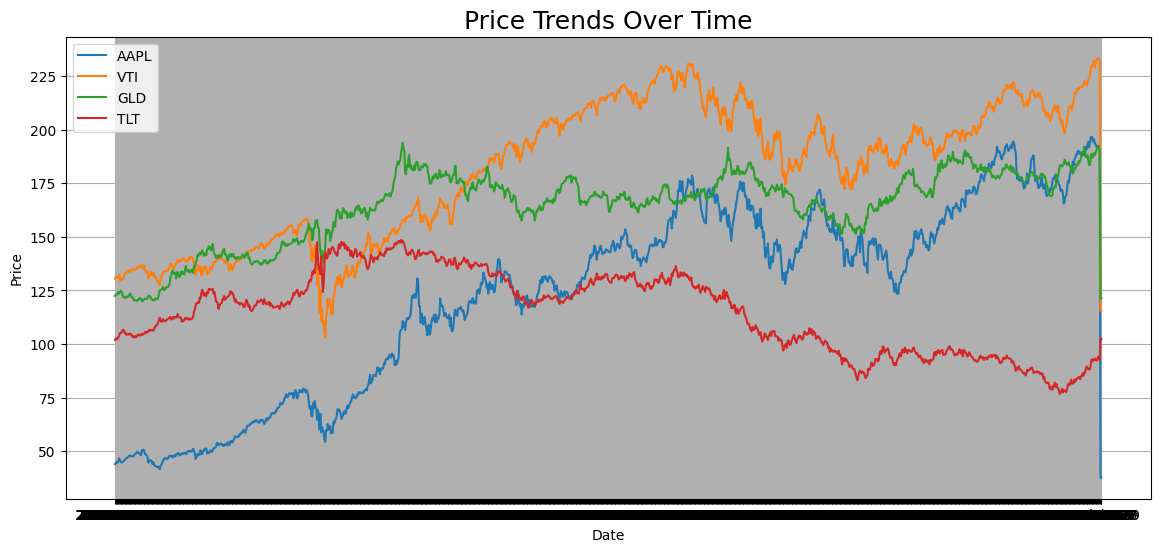

In [121]:
# Plotting the Price Trends Over Time
plt.figure(figsize=(14, 6))

for asset in ['AAPL', 'VTI', 'GLD', 'TLT']:
    plt.plot(df[f'{asset}_Close'], label=asset)

plt.title("Price Trends Over Time", fontsize=18)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

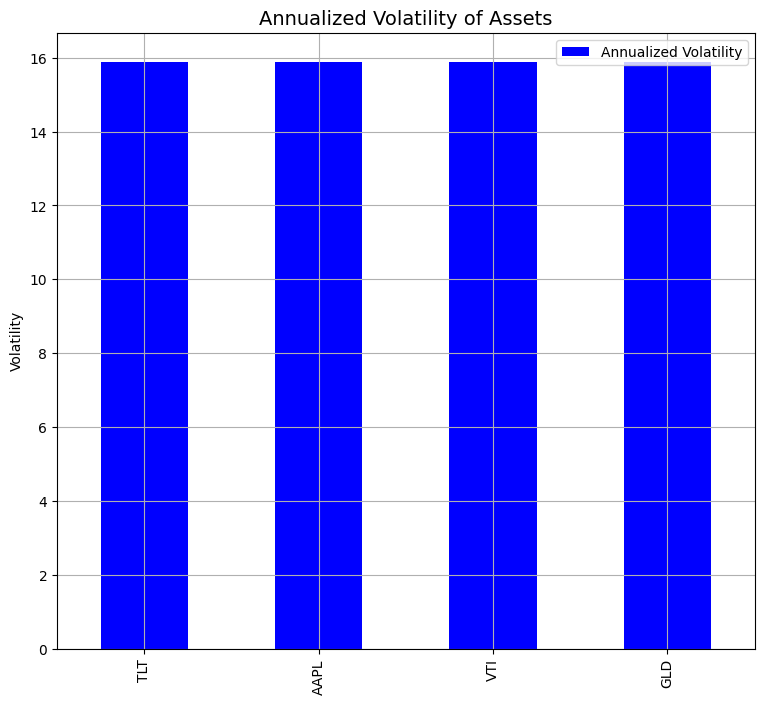

In [122]:
# Plotting the Volatility (Standard Deviation of Daily Returns)
volatility = {
    asset: df[f'{asset}_Daily Return'].std() * np.sqrt(252)  # annualized
    for asset in ['AAPL', 'VTI', 'GLD', 'TLT']
}

vol_df = pd.DataFrame.from_dict(volatility, orient='index', columns=['Annualized Volatility'])
vol_df.sort_values('Annualized Volatility', ascending=False).plot(kind='bar', figsize=(9, 8), color='blue')
plt.title("Annualized Volatility of Assets", fontsize=14)
plt.ylabel("Volatility")
plt.grid(True)
plt.show()

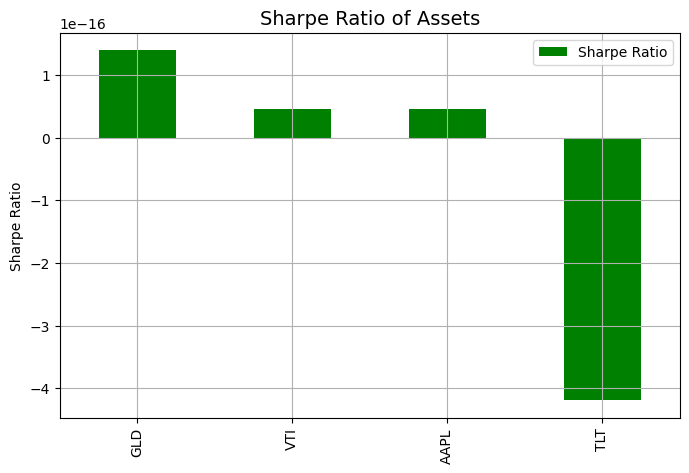

In [123]:
# Plotting the Sharpe Ratio
sharpe_ratios = {
    asset: df[f'{asset}_Daily Return'].mean() / df[f'{asset}_Daily Return'].std() * np.sqrt(252)
    for asset in ['AAPL', 'VTI', 'GLD', 'TLT']
}

sharpe_df = pd.DataFrame.from_dict(sharpe_ratios, orient='index', columns=['Sharpe Ratio'])
sharpe_df.sort_values('Sharpe Ratio', ascending=False).plot(kind='bar', figsize=(8, 5), color='green')
plt.title("Sharpe Ratio of Assets", fontsize=14)
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.show()


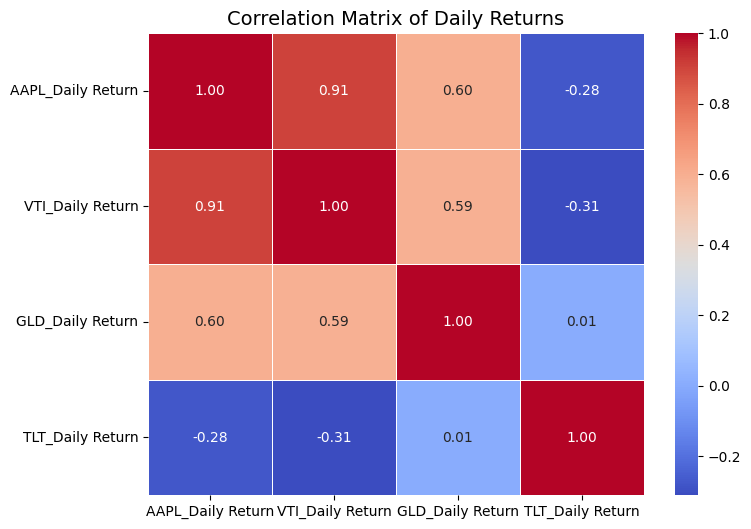

In [124]:
# Plotting the Correlation Matrix (Daily Returns)
returns_df = df[[f'{asset}_Daily Return' for asset in ['AAPL', 'VTI', 'GLD', 'TLT']]]
corr = returns_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Daily Returns", fontsize=14)
plt.show()

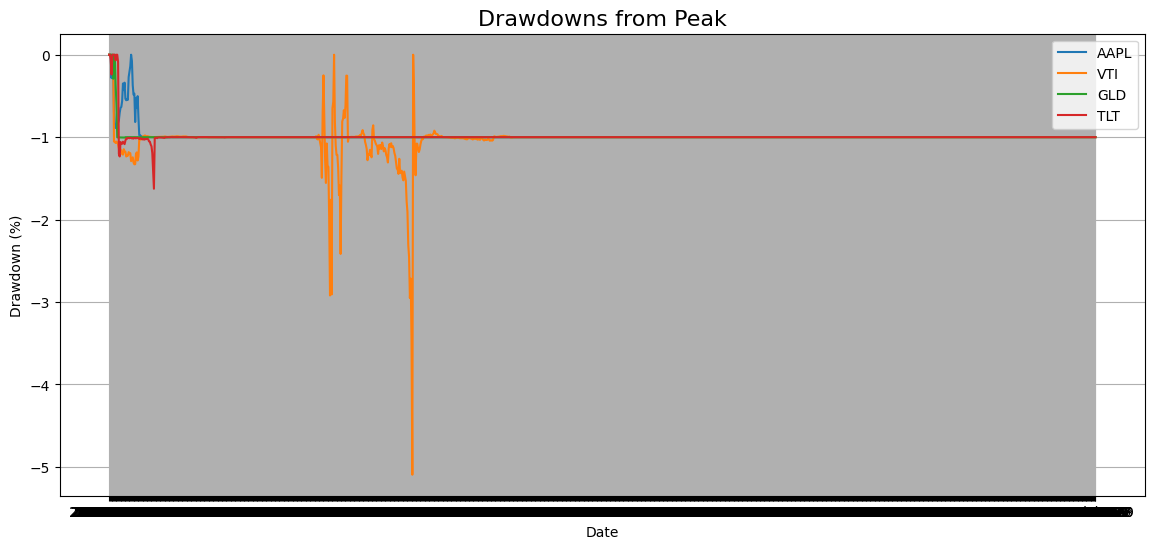

In [125]:
# Plotting the Drawdown (Max Loss from Peak)
def calculate_drawdown(series):
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown

plt.figure(figsize=(14, 6))
for asset in ['AAPL', 'VTI', 'GLD', 'TLT']:
    drawdown = calculate_drawdown(df[f'{asset}_Daily Return'])
    plt.plot(drawdown, label=asset)
plt.title("Drawdowns from Peak", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.legend()
plt.grid(True)
plt.show()


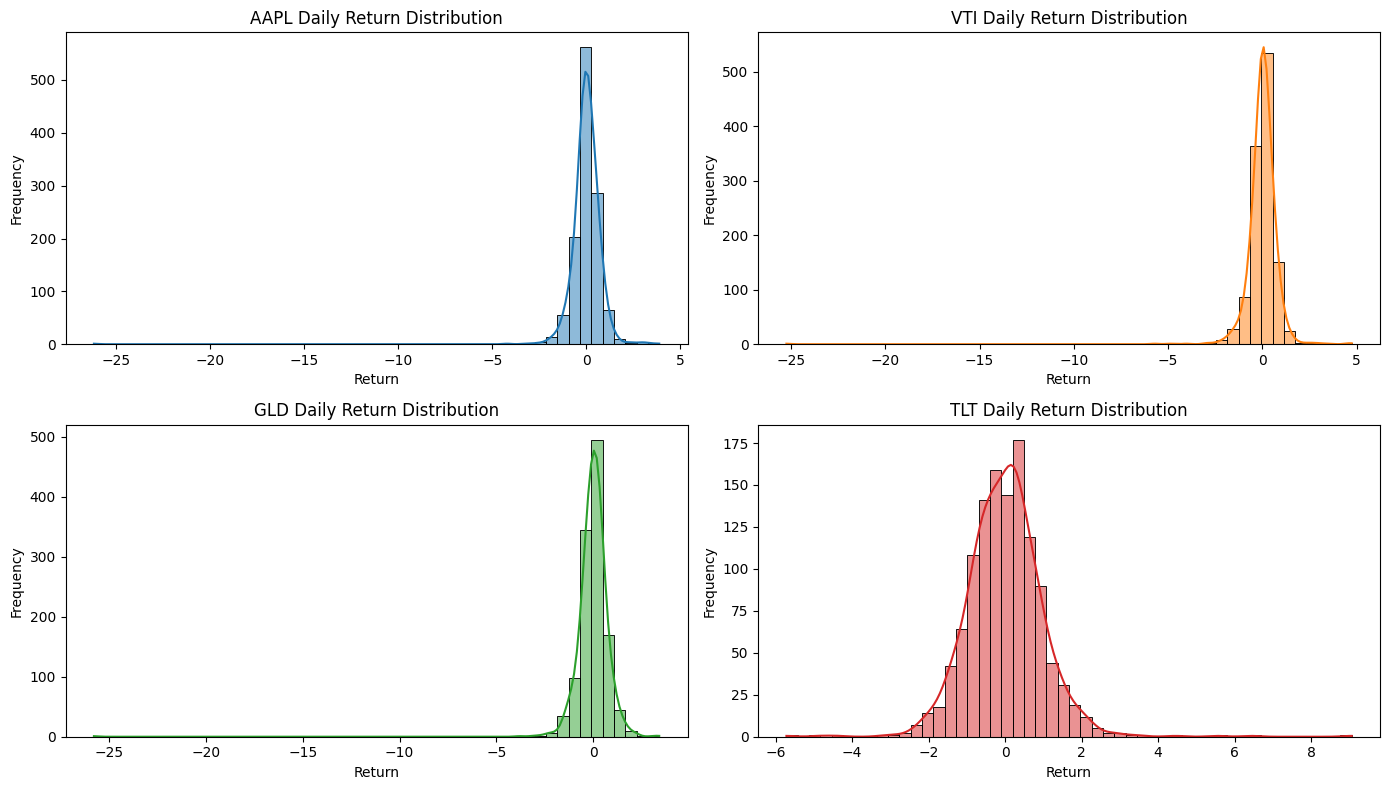

In [126]:
# Plotting the Histograms of Return Distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()
assets = ['AAPL', 'VTI', 'GLD', 'TLT']

for i, asset in enumerate(assets):
    sns.histplot(df[f'{asset}_Daily Return'], bins=50, kde=True, ax=axes[i], color=sns.color_palette()[i])
    axes[i].set_title(f"{asset} Daily Return Distribution", fontsize=12)
    axes[i].set_xlabel("Return")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# **5. Feature Engineering**

RSI stands for Relative Strength Index. It’s a popular technical indicator used to measure momentum — specifically whether an asset is overbought or oversold.

📉 Formula (simplified):

RSI = 100 − [100 / (1 + (Avg Gain / Avg Loss))]
Usually calculated over 14 days.

✅ Why Are We Computing RSI?

If RSI > 70 → the asset is likely overbought (price may fall)

If RSI < 30 → the asset is likely oversold (price may rise)

📌 It helps the model understand reversal zones and trend strength, which is useful for:

ML: better classification of “buy/sell/hold” periods
DL: learning price movement patterns
Portfolio Optimization: avoid allocating to overheated assets

In short: RSI adds “emotional context” to price data.

In [127]:
# Function to compute RSI
def compute_RSI(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [128]:
# Function to compute Z-score of returns
def compute_return_zscore(series, window=21):
    mean = series.rolling(window).mean()
    std = series.rolling(window).std()
    return (series - mean) / std

In [129]:
# Function to compute Drawdown
def compute_drawdown(series):
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    return (cumulative - peak) / peak

In [130]:
# Function to add all the advanced features
def add_advanced_features(df):
    assets = ['AAPL', 'VTI', 'GLD', 'TLT']

    for asset in assets:
        close = df[f'{asset}_Close']

        df[f'{asset}_RSI'] = compute_RSI(close)
        df[f'{asset}_Return_ZScore'] = compute_return_zscore(close.pct_change())
        df[f'{asset}_Drawdown'] = compute_drawdown(close.pct_change())

    return df

In [131]:
# Implementing the function above in the combined dataset - df :
df = add_advanced_features(df)

print(df)

            AAPL_Close   AAPL_High    AAPL_Low   AAPL_Open  AAPL_Volume  \
Date                                                                      
2019-03-14   43.953716   44.042234   43.673818   43.994385   94318000.0   
2019-03-15   44.525471   44.814941   43.956106   44.221651  156171600.0   
2019-03-18   44.980015   45.068529   44.446529   44.448924  104879200.0   
2019-03-19   44.623554   45.212061   44.477624   45.058954  126585600.0   
2019-03-20   45.013500   45.331676   44.192940   44.551785  124140800.0   
...                ...         ...         ...         ...          ...   
2023-12-27  191.745819  192.093281  189.700797  191.090629   48087700.0   
2023-12-28  192.172699  193.244849  191.765676  192.728625   34049900.0   
2023-12-29  191.130325  192.986726  190.336138  192.490361   42672100.0   
Date         37.617847   37.839383   36.738858   36.896077  148158800.0   
Ticker       37.617847   37.839383   36.738858   36.896077  148158800.0   

            AAPL_Daily R

In [132]:
# Calculate Mean Returns and Covariance Matrix
# Get daily returns only
returns = df[[f'{asset}_Daily Return' for asset in ['AAPL', 'VTI', 'GLD', 'TLT']]]

# Drop NaNs if RSI introduced them
returns.dropna(inplace=True)

# Mean returns (annualized)
mean_returns = returns.mean() * 252

# Covariance matrix (annualized)
cov_matrix = returns.cov() * 252

print("Mean Returns:\n", mean_returns)
print("\nCovariance Matrix:\n", cov_matrix)

Mean Returns:
 AAPL_Daily Return    7.392930e-16
VTI_Daily Return     7.392930e-16
GLD_Daily Return     2.217879e-15
TLT_Daily Return    -6.653637e-15
dtype: float64

Covariance Matrix:
                    AAPL_Daily Return  VTI_Daily Return  GLD_Daily Return  \
AAPL_Daily Return         252.208264        228.432068        150.972596   
VTI_Daily Return          228.432068        252.208264        149.153050   
GLD_Daily Return          150.972596        149.153050        252.208264   
TLT_Daily Return          -70.223155        -78.423067          1.491292   

                   TLT_Daily Return  
AAPL_Daily Return        -70.223155  
VTI_Daily Return         -78.423067  
GLD_Daily Return           1.491292  
TLT_Daily Return         252.208264  


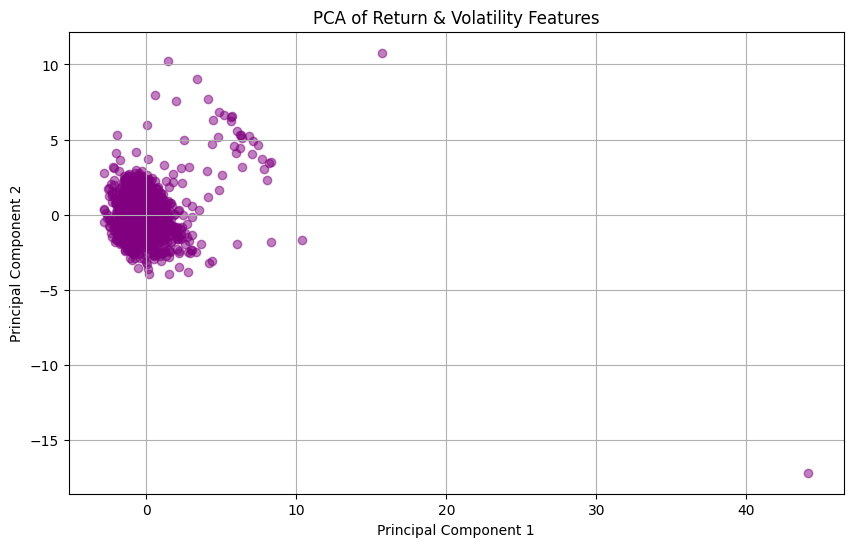

In [133]:
# Adding PCA :
from sklearn.decomposition import PCA

# Keep only return/volatility-based features for PCA
features_for_pca = df[[col for col in df.columns if 'Return' in col or 'Volatility' in col]]
features_for_pca.dropna(inplace=True)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_for_pca)

# Create DataFrame
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=features_for_pca.index)

# Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c='purple', alpha=0.5)
plt.title("PCA of Return & Volatility Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

# **6. Portfolio Optimization**

In [134]:
# Installing PyPortfolioOpt
!pip install PyPortfolioOpt

In [135]:
# Importing the required functions
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

In [136]:
# DataFrame
df.head()

,AAPL_Close,AAPL_High,AAPL_Low,AAPL_Open,AAPL_Volume,AAPL_Daily Return,AAPL_Cumulative Return,AAPL_MA10,AAPL_MA50,AAPL_Rolling Volatility,...,AAPL_Drawdown,VTI_RSI,VTI_Return_ZScore,VTI_Drawdown,GLD_RSI,GLD_Return_ZScore,GLD_Drawdown,TLT_RSI,TLT_Return_ZScore,TLT_Drawdown
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-14,43.953716,44.042234,43.673818,43.994385,94318000.0,0.337176,-1.796991,42.380299,39.493817,-0.796880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-15,44.525471,44.814941,43.956106,44.221651,156171600.0,0.398786,-1.784129,42.647040,39.631970,-0.785209,...,0.000000,NaN,NaN,0.000000,NaN,NaN,0.0,NaN,NaN,0.000000
2019-03-18,44.980015,45.068529,44.446529,44.448924,104879200.0,0.307604,-1.773904,42.938183,39.854153,-0.781338,...,0.000000,NaN,NaN,0.000000,NaN,NaN,0.0,NaN,NaN,-0.000575
2019-03-19,44.623554,45.212061,44.477624,45.058954,126585600.0,-0.283024,-1.781923,43.201336,40.040289,-0.860225,...,-0.007925,NaN,NaN,-0.000206,NaN,NaN,0.0,NaN,NaN,-0.002792
2019-03-20,45.013500,45.331676,44.192940,44.551785,124140800.0,0.259723,-1.773151,43.527644,40.235796,-0.889335,...,0.000000,NaN,NaN,-0.004328,NaN,NaN,0.0,NaN,NaN,0.000000


In [143]:
# Extract Close prices of new asset list
price_df = df_scaled[[f'{asset}_Close' for asset in ['GLD', 'AAPL', 'VTI', 'TLT']]]
price_df.columns = ['GLD', 'AAPL', 'VTI', 'TLT']  # Rename for PyPortfolioOpt compatibility
price_df.dropna(inplace=True)  # Ensure clean data
price_df

,GLD,AAPL,VTI,TLT
Date,,,,
2019-03-14,122.410004,43.953716,130.392624,101.855919
2019-03-15,122.970001,44.525471,130.997864,102.529594
2019-03-18,123.040001,44.980015,131.485718,102.470665
2019-03-19,123.379997,44.623554,131.458633,102.243317
2019-03-20,124.180000,45.013500,130.916595,103.312813
...,...,...,...,...
2023-12-27,192.589996,191.745819,233.563522,94.140114
2023-12-28,191.470001,192.172699,233.445892,93.456375
2023-12-29,191.169998,191.130325,232.553802,92.613388


In [144]:
# Compute expected returns (mean annualized)
mu = mean_historical_return(price_df)                       # Annualized mean returns
# Compute covariance matrix using Ledoit-Wolf shrinkage
S = CovarianceShrinkage(price_df).ledoit_wolf()

In [145]:
# Optimizing Portfolio & Maximize Sharpe Ratio
ef = EfficientFrontier(mu, S)
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()

Expected annual return: 0.1%
Annual volatility: 27.8%
Sharpe Ratio: 0.00


In [140]:
# Compute Portfolio Metrics
expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance(verbose=True)

Expected annual return: -0.8%
Annual volatility: 17.2%
Sharpe Ratio: -0.05


In [141]:
# Output Results
print("Optimal Weights:\n", cleaned_weights)
print(f"Expected Return: {expected_annual_return:.2%}")
print(f"Volatility: {annual_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Optimal Weights:
 OrderedDict([('AAPL', 0.08846), ('VTI', 0.22014), ('GLD', 0.27907), ('TLT', 0.41234)])
Expected Return: -0.84%
Volatility: 17.16%
Sharpe Ratio: -0.05


# **7. Machine Learning**

# **8. Deep Learning for Trend Prediction**